Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

Перед нами поставлено две задачи:
- Провести приоретизацию гипотиз по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Для приоретизации мы используем два фреймворка: ICE и RICE.  
- Проанализировать результаты проведенных А/B-тестов. 

Для анализа результатов А/B-тестов мы имеем два датасета с данными о заказах и с данными о посетителях. Проанализируем выручку, средний чек, среднее количество заказов по группам по "сырым" и очищенным от выбросов данным. И примем решение по результатам теста: остановить тест с отрицательным или положительным результатом, либо продлить тест.

## Предобратотка данных

In [1]:
# Импортируем необходимые библиотеки, загрузим данные
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
import math as mth
from scipy import stats as st

In [2]:
# устанавливаем отображение количества столбцов экране 
pd.options.display.max_columns = 40
pd.options.display.max_colwidth = 150
pd.options.display.float_format = '{:.2f}'.format # устанавливаем отображение числа знаков после точки.
import warnings
warnings.filterwarnings('ignore')

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
# Посмотрим на формат данных и их состав
hypothesis.info()
# Выведем 5 первых строк данных таблицы hypothesis
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [5]:
# Посмотрим на формат данных и их состав
orders.info()
# Выведем 5 первых строк данных таблицы orders
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
# Посмотрим на формат данных и их состав
visitors.info()
# Выведем 5 первых строк данных таблицы visitors
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Перед нами три датасета: таблица с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. И два - с результати проведенных А/В тестов.
В таблице hypothesis 9 строк, orders - 1197, visitors - 62. Типы данных: int, object.

Перед началом исследования изменим наименование столбцов, проверим датасет на пропуски и дубликаты и изменим тип данных у столбцов с датой.

In [7]:
# Приведем наименование столбцов в таблицах к строчным буквам
hypothesis.columns = [x.lower().replace(' ', '_') for x in hypothesis.columns.values]
display(hypothesis.columns)
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
display(orders.columns)
visitors.columns = [x.lower().replace(' ', '_') for x in visitors.columns.values]
display(visitors.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')

Index(['date', 'group', 'visitors'], dtype='object')

In [8]:
# Проверим наличие пропусков и дубликатов
print(visitors.isna().sum())
print(visitors.duplicated().sum())

print(orders.isna().sum())
print(orders.duplicated().sum())

print(hypothesis.isna().sum())
print(hypothesis.duplicated().sum())

date        0
group       0
visitors    0
dtype: int64
0
transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64
0
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
0


In [9]:
# Приведем столбцы с датами к верным типам данных
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Пропусков и дубликатов в данных нет. Тип данных изменили. Можно приступать к исследованию.

In [10]:
#Продтвердим количество групп а A/B-тесте
display(visitors['group'].unique())
display(orders['group'].unique())

array(['A', 'B'], dtype=object)

array(['B', 'A'], dtype=object)

В данных только две группы: А и В. Отлично

In [11]:
#Посмотрим распределние количества пользователей в каждой группе
display(visitors.groupby('group')['visitors'].nunique())
display(orders.groupby('group')['visitorid'].nunique())

group
A    31
B    30
Name: visitors, dtype: int64

group
A    503
B    586
Name: visitorid, dtype: int64

Распределение в датасете orders неравное: в группе В пользователей больше на 14%. Но это вполне допустимо, так как это говорит лишь о несбалансированности, а не о некорректности. 

In [12]:
#Проверим не попадают ли пользователи в обе группы
len(np.intersect1d(orders.query('group == "A"')['visitorid'].unique(), orders.query('group == "B"')['visitorid'].unique()))

58

58 пользователей присутствуют в обоих группах. От общего количества пользователей это лишь 5%, что допустимо. Примем решение не удалять данных пользователей.

## Приоритизация гипотез

### Применение фреймворка ICE для приоритизации гипотез

In [13]:
hypothesis['ICE'] = ((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'])
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE 8, 0, 7

### Применение фреймворка RICE для приоритизации гипотез

In [14]:
hypothesis['RICE'] = ((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'])
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Наиболее перспективные гипотезы по RICE 7, 2, 0, 6

###  Изменение приоритизации гипотез при применении RICE вместо ICE

In [15]:
hypothesis.sort_values(by=['RICE'], ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


Мы видим разные перспективные гипотизы по разным фреймворкам. На значение RICE, в отличие от ICE, также влияет оценка охвата: сколько пользователей(reach) затронет то ли иное изменение.

Я рекомендую обратить внимание на гипотезу №7 - она имеет максимальных охват, высокий показатель и влияния(impact), и уверенности(confidence) при средних трудозатратах(efforts).
Также обратить внимание на гипотезу №0 - при низком охвате, мы видим максимальное значение влияния, и трудозатраты чуть выше среднего. 
Гипотеза №2 может быть успешной: при хорошем охвате и низких трудозатратах. Да, коллеги ей присвоили низкий уровень влияния, но я бы не недооценивала рекомендации товаров, как способ увеличения среднего чека.

## Анализ A/B-теста

### Соберем кумулятивные данные

Соберем кумулятивные данные. Объявим датафрейм cumulativeData со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [16]:
orders, visitors

(      transactionid   visitorid       date  revenue group
 0        3667963787  3312258926 2019-08-15     1650     B
 1        2804400009  3642806036 2019-08-15      730     B
 2        2961555356  4069496402 2019-08-15      400     A
 3        3797467345  1196621759 2019-08-15     9759     B
 4        2282983706  2322279887 2019-08-15     2308     B
 ...             ...         ...        ...      ...   ...
 1192     2662137336  3733762160 2019-08-14     6490     B
 1193     2203539145   370388673 2019-08-14     3190     A
 1194     1807773912   573423106 2019-08-14    10550     A
 1195     1947021204  1614305549 2019-08-14      100     A
 1196     3936777065  2108080724 2019-08-15   202740     B
 
 [1197 rows x 5 columns],
          date group  visitors
 0  2019-08-01     A       719
 1  2019-08-02     A       619
 2  2019-08-03     A       507
 3  2019-08-04     A       717
 4  2019-08-05     A       756
 ..        ...   ...       ...
 57 2019-08-27     B       720
 58 2019-08-28  

In [17]:
#Создадим массив уникальных пар значений дат и групп
datesGroups = orders[['date','group']].drop_duplicates()

In [18]:
#Соберём агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

ordersAggregated.head()

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [19]:
#Соберём агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [20]:
#Объединим две таблицы в одну и переименнуем название столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### График кумулятивной выручки по группам

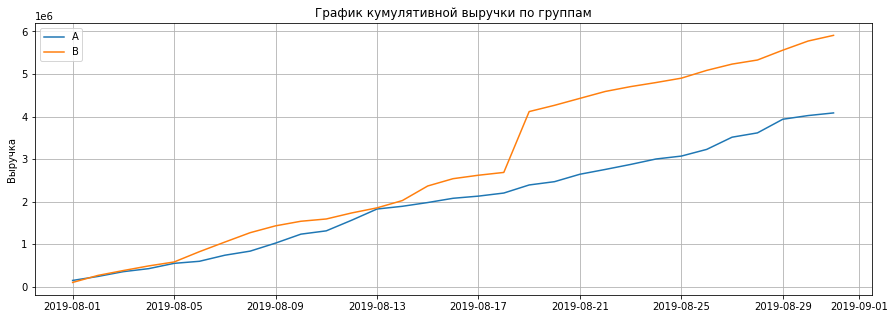

In [21]:
#Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.legend();

Выручка группы А равномерно увеличивается в течение всего теста - это хороший знак. Выручка группы Б имеет один резкий подъем: это может говорит о резком увеличении заказов либо о появлении очень дорогого заказа - возможно это будет выбросом.

### График кумулятивного среднего чека по группам

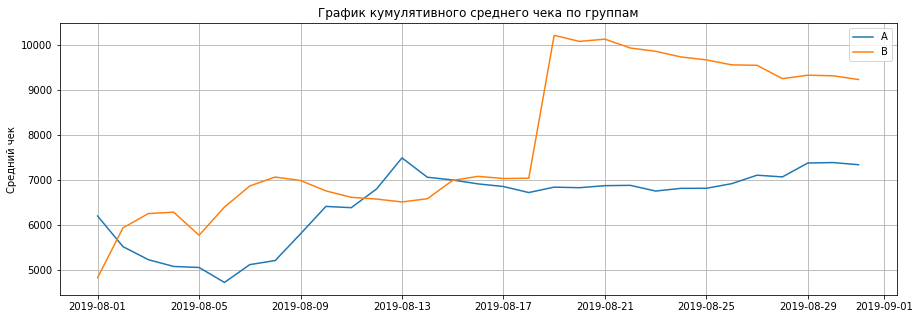

In [22]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Средний чек")
plt.legend();

Средний чек группы А становится равномерным к середине теста. В то время как группа Б показывает падение к концу теста после резкого всплеска на графике - это возможно попали крупные заказы в середине теста. Тогда ей (группе) нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### График относительного изменения кумулятивного среднего чека группы B к группе A

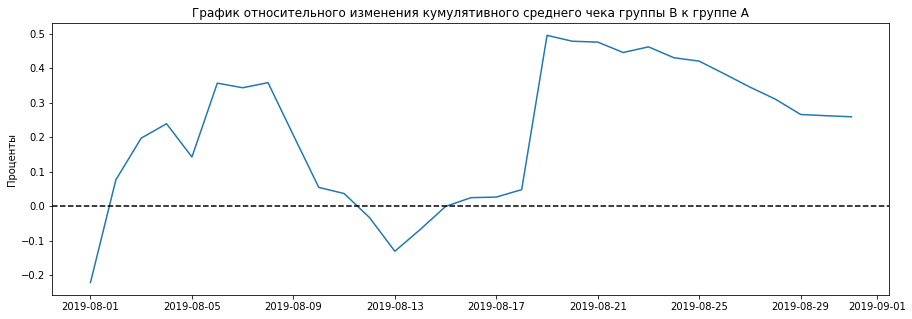

In [23]:
#Собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#Строим отношение средних чеков
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel("Проценты")
#Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

И на данном графике видим "скачки", что говорит нам о крупных заказах или выбросах.

### График кумулятивного среднего количества заказов (конверсии) на посетителя по группам 

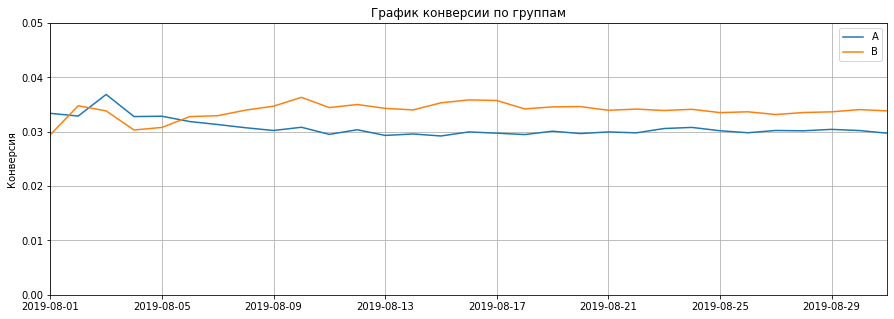

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.grid()
plt.title('График конверсии по группам')
plt.ylabel("Конверсия")
plt.legend();
#Задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05]);

В начале теста мы видим скачок у обоих групп и преимущество у группы А. Через неделю показатели конверсии группы В становятся выше - эта тенденция остается до конца теста. В конце 11 дня наблюдаем еще один "всполох" (в группе В он чуть больше). К концу теста значения равномерны.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

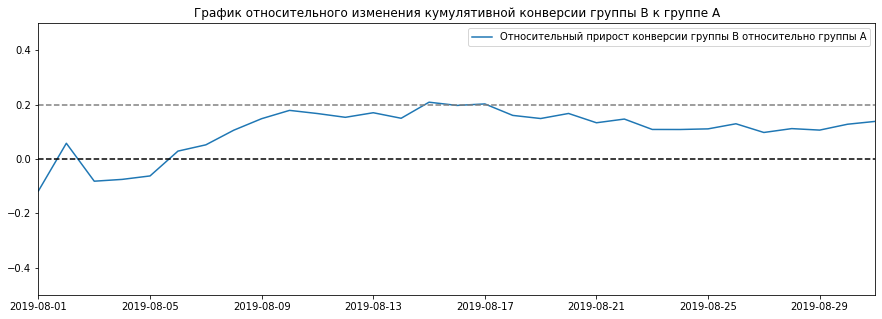

In [25]:
#Собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#Строим отношение конверсий
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label='Относительный прирост конверсии группы B относительно группы A')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.legend()
#Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.5, 0.5]); 

В начале теста конверсия группы В была ниже группы А, к середине теста - превысила на 20%, ближе к концу изменения остановилось на уровне 15-10%.

### Точечный график количества заказов по пользователям

In [26]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [27]:
#Подсчитает число уникальных заказов по сгруппированным данным
ordersByUsers = orders.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'})
#Переименуем столбцы
ordersByUsers.columns = ['userId', 'orders']
display(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


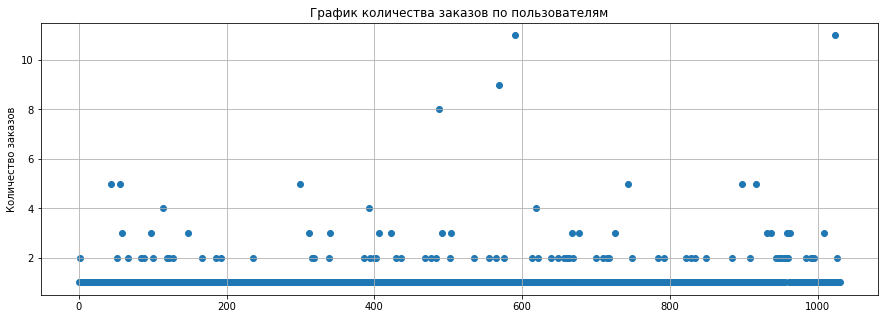

In [28]:
#Построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям')
plt.ylabel("Количество заказов")
plt.scatter(x_values, ordersByUsers['orders']) ;

Видим, что клиентов, кто сделал 2 заказа совсем немного, еще меньше - кто делал больше 2, возможно такие заказы будут считаться аномальными. Проверим.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [29]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 5% пользователей сделали больше 2 заказов. И не более 1% - более 4 заказов.

### Точечный график стоимостей заказов

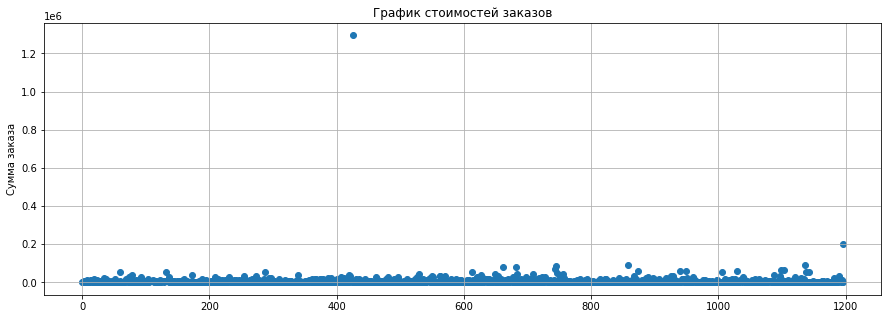

In [30]:
#Построим точечную диаграмму стоимостей заказов на одного пользователя
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.grid()
plt.title('График cтоимостей заказов')
plt.ylabel('Сумма заказа')
plt.scatter(x_values, orders['revenue']);

Видим один очень крупный аномальный заказ на сумму более более 1 200 000, заказ на сумму 200 000 также выбивается из общей статистики. В целом заказов больше 20 000 - 30 000 мало.

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [31]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Не более чем у 5% пользователей чек выше 28 000, и не больше чем у 1% - выше 58 000.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы:
- Н0: различий в среднем количестве заказов между группами нет
- Н1: различия в среднем количестве заказов между группами есть

In [32]:
#Подготовим данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date':'max', 'visitorsPerDateA':'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date':'max', 'visitorsPerDateB':'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']].groupby('date', as_index=False).agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(lambda x:ordersADaily[ordersADaily['date'] <= x['date']].agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by='date')
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']].groupby('date', as_index=False).agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(lambda x:ordersBDaily[ordersBDaily['date'] <= x['date']].agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by='date')
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [33]:
#Соберем данные в одну таблицу
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [34]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [35]:
#Применим критерий Манна-Уитни и выведем относительный прирост среднего числа заказов группы B
print('Значение по критерию Манна-Уитни:', "{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Прирост среднего часла заказов группы В:', "{0:.2%}".format(sampleB.mean() / sampleA.mean() - 1))

Значение по критерию Манна-Уитни: 0.01679
Прирост среднего часла заказов группы В: 13.81%


Значение критерия 0,017 меньше значения p-value=0.05 - значит гипотезу о равном количетсве заказов между группами отвергаем. Однако группа В показывает на 13,8% больше заказов относительно группы А.

### Статистическая значимость различий в среднем чеке заказов между группами по «сырым» данным

Сформулируем гипотезы:

- Н0: различий в среднем чеке между группами нет
- Н1: различия в среднем чеке между группами есть

In [36]:
#Применим критерий Манна-Уитни и выведем относительный прирост среднего чека группы B
print('Значение по критерию Манна-Уитни:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Прирост среднего чека группы В:','{0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Значение по критерию Манна-Уитни: 0.729
Прирост среднего чека группы В: 25.87%


Значение критерия 0,729, что больше значения p-value=0.05 - значит гипотезу о различии в среднем чеке между группами не отвергаем. Однако группа В показывает средний чек на 25,9% больше относительно группы А.

### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

В нашем исследовании мы выяснили, что лишь 5% пользователей сделали больше 2 заказов и заказов на сумму больше 28 000. Потому примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ более чем на 30 000.

In [37]:
#Сделаем срезы пользователей с заказами больше 2 и дороже 30 000
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], [95]))]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], [95]))]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [95]))]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
74


74 аномальных пользователей.

Сформулируем гипотезы:

- Н0: различий в среднем количестве заказов между группами нет
- Н1: различия в среднем количестве заказов между группами есть

In [38]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [39]:
#Применим критерий Манна-Уитни и выведем относительный прирост среднего числа заказов группы B
print('Значение по критерию Манна-Уитни:', "{0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Относительный прирост среднего числа заказов группы В:', "{0:.2%}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

Значение по критерию Манна-Уитни: 0.01304
Относительный прирост среднего числа заказов группы В: 17.27%


Значение критерия 0,013 меньше значения p-value=0.05 - значит гипотезу об утсутствии различии в среднем количестве заказов между группами отвергаем. Группа В показывает еще больший прирост заказов - 17,2% относительно группы А.

### Статистическая значимость различий в среднем чеке между группами по «очищенным» данным

Сформулируем гипотезы:

- Н0: различий в среднем чеке между группами нет
- Н1: различия в среднем чеке между группами есть

In [40]:
print(
    'Значение по критерию Манна-Уитни:','{0:.5f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Прирост среднего чека группы В:', "{0:.2%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Значение по критерию Манна-Уитни: 0.73848
Прирост среднего чека группы В: -1.96%


Значение критерия 0,720, что больше значения p-value=0.05 - значит гипотезу о различии в среднем чеке между группами не отвергаем. Однако группа В показывает средний чек на 2% меньше относительно группы А.

### Решение по результатам теста

Завершив исследование мы выяснили:
- Есть статистически значимое различия по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

Принимаем решение остановить тест и зафиксировать победу группы В: она показывает конверсию выше (на 17%), чем группа А. В значениях среднего чека разница совсем минимальная - 2% в пользу группы А.